In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np           
import seaborn as sns ; sns.set()
import re
from datetime import timedelta
from collections import OrderedDict
from chiptools import drop_emptier_dups
from chiptools import single_val_cols_to_dict

In [30]:
# function to strip the metadata:columns with only 1 unique value out of df and store in a dict with column:unique pairs
# relies on using the df.index.name as the name of key for accessing the meta_data dict from a second dictionary...
#   which stores all of the metadata dictionaries

# set df.name = '[the name of the dataframe]' before calling
# does not work with multi-index

# input:            dataframe
#                     /  \
#                    /    \
#                smaller  dict with all of the not well utilized columnar data
# output:      dataframe    


def strip_meta(df):
    meta_dict = {}
    
    # if index.name has a value, store it in the meta_dict under 'index.name'
    if df.index.name is not None:
        if df.index.name != df.name + '_meta':
            meta_dict['index.name'] = df.index.name
        else: raise UserWarning('meta_data being overwritten by strip_meta') # if the meta data has already been written
        
    df.index.name = df.name + '_meta'
    
    # DON'T NEED?? -- preserve the original columns list as meta_data
    #meta_dict['column_list'] = list(df.columns)
    # What about storing del_list in meta_data??s
    
    # go through columns, if only 1 unique value, store in meta_dict with column_name:unique pair and remove column
    del_list = []
    for col in df.columns:
        if df[col].nunique(dropna=False) == 1:
            meta_dict[col] = df.loc[df.index[0],col]
            del_list.append(col)
    if len(del_list) > 0:
        df.drop(del_list, axis = 'columns', inplace=True)
    return (df, meta_dict)

In [31]:
int_list = [5, -2, -4, 6] 
print(n for n in int_list if n < 0)

<generator object <genexpr> at 0x1a183942b0>


In [32]:
# read in the csv and clean down to just the 'Sample Measurement' column while saving the other columns as meta_data

meta_meta_dict = {}    #create the dictionary which will pair the meta_data key held in df.index.name to the meta_data dictionary for that df

# read in the csv
sr_25 = pd.read_csv('SantaRosaJul-Nov17PM2.5.txt', 
                    parse_dates={'datetime_local':['Date Local','24 Hour Local'],'datetime_gmt':['Date GMT','24 Hour GMT']}) #,
#                    index_col='Date Local_24 Hour Local')

# remove END OF FILE entry if it exists from last line
if any('END OF FILE' in val for val in sr_25.iloc[-1]):
    sr_25.drop(sr_25.index.values[-1], inplace=True)

sr_25['datetime_local'] = pd.to_datetime(sr_25['datetime_local'])
sr_25.set_index('datetime_local', inplace=True)
sr_25['datetime_gmt'] = pd.to_datetime(sr_25['datetime_gmt'])
sr_25.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3640 entries, 2017-07-04 23:00:00 to 2017-11-03 01:00:00
Data columns (total 22 columns):
datetime_gmt               3640 non-null datetime64[ns]
Latitude                   3640 non-null object
Longitude                  3640 non-null float64
Datum                      3640 non-null object
Horizontal Accuracy        3640 non-null float64
State Code                 3640 non-null float64
County Code                3640 non-null float64
Site Num                   3640 non-null float64
Parameter Code             3640 non-null float64
POC                        3640 non-null float64
AQS Parameter Desc         3640 non-null object
Year GMT                   3640 non-null float64
Day In Year GMT            3640 non-null float64
Sample Measurement         3640 non-null float64
Units of Measure           3640 non-null object
Sample Duration            3640 non-null object
Sample Frequency           0 non-null float64
Detection Limit          

In [33]:
#test_cols = ['col'+ str(x) for x in range(5)]
#print(test_cols)
single_nans = True
nans_count = True

single_cols=(0, 2, 4)
random_cols=(1, 3)
nan_cols=None

expected_cols = []
if single_cols and single_nans and nans_count: expected_cols.extend(single_cols)
if random_cols: expected_cols.extend(random_cols)
expected_cols = ['col' + str(x) for x in sorted(expected_cols)]

print(expected_cols)

['col0', 'col1', 'col2', 'col3', 'col4']


In [34]:
col_name = 'Sample Frequency'
test_dict = {}
print(sr_25[col_name].first_valid_index())
print(type(sr_25[col_name].first_valid_index()))

for col_name in sr_25.columns:
    if sr_25[col_name].first_valid_index() is not None:
        test_dict[col_name] = sr_25.at[sr_25[col_name].first_valid_index(),col_name]
        print(sr_25.at[sr_25[col_name].first_valid_index(),col_name])
        print(type(sr_25.at[sr_25[col_name].first_valid_index(),col_name]))
    else:
        test_dict[col_name] = np.NaN
    
print(test_dict)

None
<class 'NoneType'>
2017-07-05 07:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
38.403765
<class 'str'>
-122.818294
<class 'numpy.float64'>
WGS84
<class 'str'>
2.0
<class 'numpy.float64'>
6.0
<class 'numpy.float64'>
97.0
<class 'numpy.float64'>
4.0
<class 'numpy.float64'>
88101.0
<class 'numpy.float64'>
3.0
<class 'numpy.float64'>
PM2.5 - Local Conditions
<class 'str'>
2017.0
<class 'numpy.float64'>
186.0
<class 'numpy.float64'>
2.0
<class 'numpy.float64'>
Micrograms/cubic meter (LC)
<class 'str'>
1 HOUR
<class 'str'>
5.0
<class 'numpy.float64'>
Wildfire-U. S.
<class 'str'>
Equivalent
<class 'str'>
Met One BAM-1020 Mass Monitor w/VSCC-Beta Attenuation
<class 'str'>
{'datetime_gmt': Timestamp('2017-07-05 07:00:00'), 'Latitude': '38.403765', 'Longitude': -122.818294, 'Datum': 'WGS84', 'Horizontal Accuracy': 2.0, 'State Code': 6.0, 'County Code': 97.0, 'Site Num': 4.0, 'Parameter Code': 88101.0, 'POC': 3.0, 'AQS Parameter Desc': 'PM2.5 - Local Conditions', 'Year GMT': 2017.

In [35]:
#sr_25.name = 'sr_25'   # set the name attribute for use within the strip_meta function

#strip the metadata from the df
sr_25, meta_meta_dict[sr_25.index.name] = single_val_cols_to_dict(sr_25, dict_name = 'sr_25')

# for this particular data set, remove the GMT columns while saving their range in the meta_data
meta_meta_dict[sr_25.index.name]['datetime_gmt']=[sr_25['datetime_gmt'].min(),sr_25['datetime_gmt'].max()]
meta_meta_dict[sr_25.index.name]['Day In Year GMT']=[sr_25['Day In Year GMT'].min(),sr_25['Day In Year GMT'].max()]
sr_25.drop(['datetime_gmt', 'Day In Year GMT'], axis = 'columns', inplace=True)

sr_25.sort_index(inplace=True)

#display the results
display(sr_25.tail(12))
print(meta_meta_dict[sr_25.index.name])

,Sample Measurement,Qualifier Description
sr_25,,
2017-11-30 12:00:00,5.0,NaN
2017-11-30 13:00:00,4.0,NaN
2017-11-30 14:00:00,6.0,NaN
2017-11-30 15:00:00,11.0,NaN
2017-11-30 16:00:00,8.0,NaN
2017-11-30 17:00:00,15.0,NaN
2017-11-30 18:00:00,11.0,NaN
2017-11-30 19:00:00,17.0,NaN
2017-11-30 20:00:00,13.0,NaN


{'index.name': 'datetime_local', 'Latitude': '38.403765', 'Longitude': -122.818294, 'Datum': 'WGS84', 'Horizontal Accuracy': 2.0, 'State Code': 6.0, 'County Code': 97.0, 'Site Num': 4.0, 'Parameter Code': 88101.0, 'POC': 3.0, 'AQS Parameter Desc': 'PM2.5 - Local Conditions', 'Year GMT': 2017.0, 'Units of Measure': 'Micrograms/cubic meter (LC)', 'Sample Duration': '1 HOUR', 'Sample Frequency': nan, 'Detection Limit': 5.0, 'Measurement Uncertainty': nan, 'Method Type': 'Equivalent', 'Method Description': 'Met One BAM-1020 Mass Monitor w/VSCC-Beta Attenuation', 'datetime_gmt': [Timestamp('2017-07-01 08:00:00'), Timestamp('2017-12-01 07:00:00')], 'Day In Year GMT': [182.0, 335.0]}


In [36]:
# look at sr_25 for data above CUTOFF value 
# make Qualifier Description a category
sr_25.fillna({'Qualifier Description':'No Qualifier'}, inplace=True)
sr_25['Qualifier Description'] = sr_25['Qualifier Description'].astype('category')
sr_25.info()

# find the days where readings above CUTOFF occur
CUTOFF = 50
aboveCut = sr_25.loc[sr_25['Sample Measurement'] > CUTOFF]
print(aboveCut.shape)

# create function to agg on 'Qualifier Description' column
most_common = lambda x: x.value_counts(dropna=False).index[0] if len(x.value_counts(dropna=False)) > 0 else np.NaN

# resample based on day
reCut = aboveCut.resample('D').agg({'Sample Measurement': 'max', 
                                    'Qualifier Description': most_common}) \
                                    .dropna(subset=['Sample Measurement'])
print(reCut)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3640 entries, 2017-07-01 00:00:00 to 2017-11-30 23:00:00
Data columns (total 2 columns):
Sample Measurement       3640 non-null float64
Qualifier Description    3640 non-null category
dtypes: category(1), float64(1)
memory usage: 60.5 KB
(61, 2)
            Sample Measurement Qualifier Description
sr_25                                               
2017-08-31                62.0          No Qualifier
2017-09-03                61.0        Wildfire-U. S.
2017-09-04               104.0        Wildfire-U. S.
2017-10-09               178.0          No Qualifier
2017-10-10               283.0          No Qualifier
2017-10-11                53.0          No Qualifier
2017-10-13               119.0          No Qualifier
2017-10-14                57.0          No Qualifier
2017-10-15                72.0          No Qualifier
2017-10-16               122.0          No Qualifier


In [37]:
# add a column that contains the color coding for AQI readings
# rgb values found here: http://wiki.esipfed.org/images/3/39/AIRNow_Gateway_-_web_services_fact_sheet.pdf

aqi_dict = OrderedDict([('good', {'low':0, 'high': 50, 'color':'#00E400', 'descriptor':'Good'}),
            ('mod', {'low':51, 'high': 100, 'color':'#ffff00', 'descriptor':'Moderate'}),
            ('sens', {'low':101, 'high': 150, 'color':'#FF7E00', 'descriptor':'Unhealthy for Sensitive Groups'}),
            ('unh', {'low':151, 'high': 200, 'color':'ff0000', 'descriptor':'Unhealthy'}),
            ('vun', {'low':201, 'high': 300, 'color':'#99004C', 'descriptor':'Very Unhealthy'}),
            ('haz', {'low':301, 'high': 10000, 'color':'#4C0026', 'descriptor':'Hazardous'})]) #high is actually 500, but want this to be highest category for numbers out of range

def get_aqi_color(row):
    for dct in aqi_dict.values(): 
        if row['Sample Measurement'] <= dct['high']:
            return(dct['color'])

sr_25['aqi_color'] = sr_25.apply(get_aqi_color, axis=1).astype('category')
display(sr_25.head(10))
sr_25.info()

,Sample Measurement,Qualifier Description,aqi_color
sr_25,,,
2017-07-01 00:00:00,9.0,No Qualifier,#00E400
2017-07-01 01:00:00,6.0,No Qualifier,#00E400
2017-07-01 02:00:00,7.0,No Qualifier,#00E400
2017-07-01 03:00:00,4.0,No Qualifier,#00E400
2017-07-01 04:00:00,5.0,No Qualifier,#00E400
2017-07-01 05:00:00,4.0,No Qualifier,#00E400
2017-07-01 06:00:00,5.0,No Qualifier,#00E400
2017-07-01 07:00:00,15.0,No Qualifier,#00E400
2017-07-01 08:00:00,6.0,No Qualifier,#00E400


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3640 entries, 2017-07-01 00:00:00 to 2017-11-30 23:00:00
Data columns (total 3 columns):
Sample Measurement       3640 non-null float64
Qualifier Description    3640 non-null category
aqi_color                3640 non-null category
dtypes: category(2), float64(1)
memory usage: 64.3 KB


In [38]:
wf = sr_25[sr_25['Qualifier Description']=='Wildfire-U. S.']

In [68]:
# from DataCamp Statistical Thinking Part 1 - Computing the ECDF
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

,Sample Measurement,Qualifier Description,aqi_color
sr_25,,,
2017-09-01 00:00:00,24.0,Wildfire-U. S.,#00E400
2017-09-01 01:00:00,22.0,Wildfire-U. S.,#00E400
2017-09-01 02:00:00,25.0,Wildfire-U. S.,#00E400
2017-09-01 03:00:00,25.0,Wildfire-U. S.,#00E400
2017-09-01 04:00:00,26.0,Wildfire-U. S.,#00E400


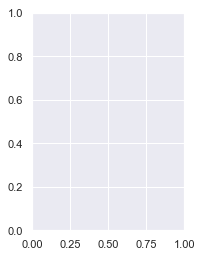

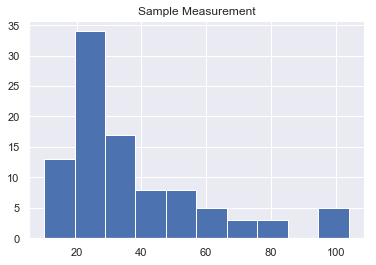

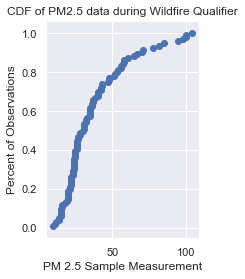

In [75]:
display(wf.head())
wf.shape

_ = plt.subplot(1, 2, 1)
wf.hist()

plt.show()
ax2 = plt.subplot(1, 2, 2)
wf_x, wf_y = ecdf(wf['Sample Measurement'])
_ = ax2.scatter(wf_x, wf_y)
_ = ax2.set_title('CDF of PM2.5 data during Wildfire Qualifier')
_ = ax2.set_xlabel('PM 2.5 Sample Measurement')
_ = ax2.set_ylabel('Percent of Observations')
plt.show()

I was surprised to find that a second column had variable data.  The 'Qualifier Description' column contains 96 values (4 days) that are categorized as being qualified with the description 'Wildfire-U. S.'  It is unclear whether this is coded as INFORM or REQEXC("required when submitting data that is affected by an Exceptional Event and for which an exclusion will be requested").

Search Wildfire on this page: https://aqs.epa.gov/aqsweb/documents/codetables/qualifiers.html
Additional information: https://www.epa.gov/aqs/aqs-code-list

Despite the following statement found here https://arb.ca.gov/aaqm/qa/drupal/ncoast_data_management.pdf:
"Most times an exceptional event such as wild fire, high winds, or fireworks occur, all of the hourly average data for the affected time periodare flagged with the appropriate “request for exclusion” flag in AQS," the qualifier code list found in the apendices only lists the INFORM version of the qualifier.

Verified that it is INFORM version of qualifier for Wildfire: IT by downloading AQSCVS version of data

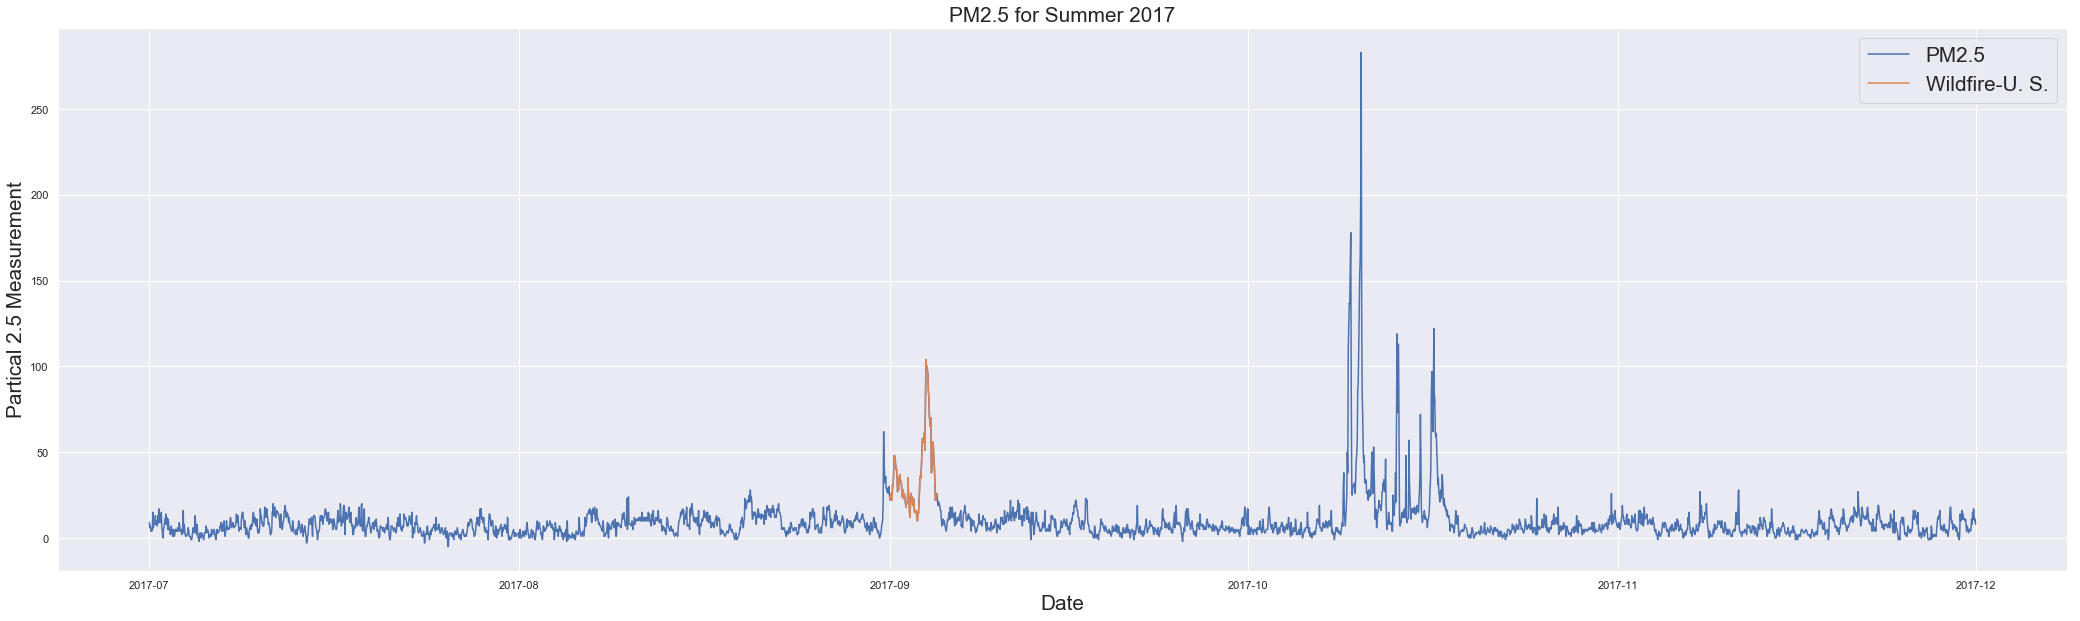

In [40]:
plt.clf()
sns.lineplot(sr_25.index, sr_25['Sample Measurement'], label='PM2.5') #, hue=sr_25['aqi_color']) #want to use aqi_color to color line but is currently not working
sns.lineplot(wf.index, wf['Sample Measurement'], label='Wildfire-U. S.')
plt.title('PM2.5 for Summer 2017', fontsize='xx-large')
plt.xlabel('Date', fontsize='xx-large')
plt.ylabel('Partical 2.5 Measurement', fontsize='xx-large')
plt.legend(fontsize='xx-large')
fig = plt.gcf()
fig.set_size_inches(36, 10)
plt.show()

In [41]:
# read in the Weather csv
sr_We = pd.read_csv('SantaRosaJul-Nov17Weather.csv', 
                    parse_dates=['DATE'] ,
                    index_col='DATE')

# remove empty columns
sr_We.dropna(axis='columns', how='all', inplace=True)

# candidate for chiptools...
# remove duplicate columns (This removes any duplicated columns; in this case SOURCE and REPORT_TYPE)
to_drop = set()
from itertools import combinations
for c1, c2 in combinations(sr_We.columns, 2):
    if (sr_We[c1] == sr_We[c2]).all():
        to_drop.add(c2)
sr_We.drop(to_drop, axis='columns', inplace=True)

#peel off daily(including sunrise/sunset), monthly and ShortDuration data
daily_We = sr_We.loc[sr_We['REPORT_TYPE']=='SOD  '].copy()
daily_We.dropna(how='all', axis='columns', inplace=True)
sr_We = sr_We.loc[sr_We['REPORT_TYPE']!='SOD  ']

monthly_We = sr_We.loc[sr_We['REPORT_TYPE']=='SOM  '].copy()
monthly_We.dropna(how='all', axis='columns', inplace=True)
sr_We = sr_We.loc[sr_We['REPORT_TYPE']!='SOM  ']

#peel off FM-16 reports (see next cell)
fm_16 = sr_We.loc[sr_We['REPORT_TYPE']=='FM-16'].copy()
fm_16.dropna(how='all', axis='columns', inplace=True)
sr_We = sr_We.loc[sr_We['REPORT_TYPE']!='FM-16']

sr_We.dropna(how='all', axis='columns', inplace=True)

# save modified file for use in tests
# sr_We.to_csv('weather.csv')

#daily_We.info()
#monthly_We.info()
sr_We.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3673 entries, 2017-07-01 00:53:00 to 2017-11-30 23:53:00
Data columns (total 20 columns):
STATION                      3673 non-null int64
REPORT_TYPE                  3673 non-null object
SOURCE                       3673 non-null int64
HourlyAltimeterSetting       3673 non-null float64
HourlyDewPointTemperature    3639 non-null object
HourlyDryBulbTemperature     3635 non-null object
HourlyPrecipitation          3672 non-null object
HourlyPresentWeatherType     948 non-null object
HourlyPressureChange         1225 non-null float64
HourlyPressureTendency       1225 non-null float64
HourlyRelativeHumidity       3633 non-null float64
HourlySeaLevelPressure       3627 non-null float64
HourlySkyConditions          3639 non-null object
HourlyStationPressure        3672 non-null float64
HourlyVisibility             3651 non-null object
HourlyWetBulbTemperature     3632 non-null float64
HourlyWindDirection          3642 non-null object
Hou

## Weather Data  
Data was obtained here: https://www.ncdc.noaa.gov/cdo-web/search  
Using following settings:  
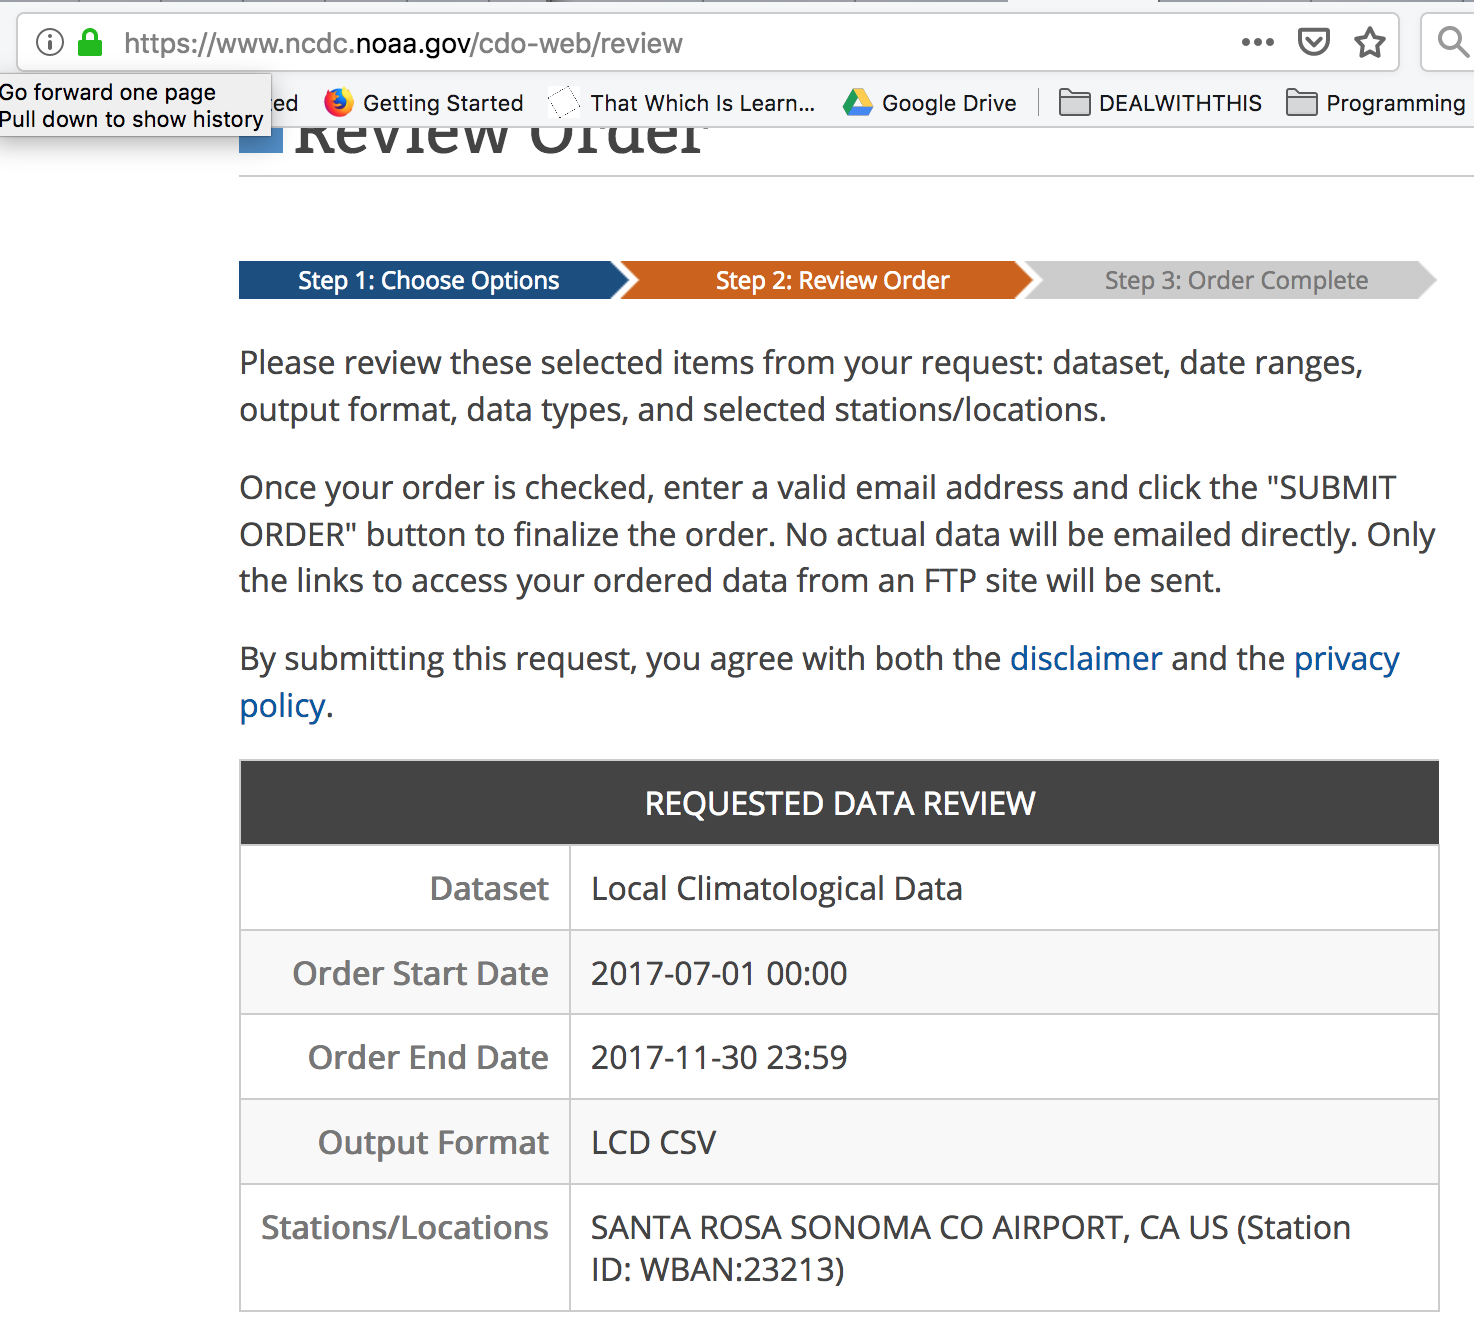

Information about data can be found here:  
https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf  

#### REPORT-TYPE codes  
Code information found here:  
https://www1.ncdc.noaa.gov/pub/data/ish/ish-format-document.pdf  

* FM-15 = METAR Aviation routine weather report  
* FM-16 = SPECI Aviation selected special weather report  

Because I only wanted hourly readings, I also removed the FM-16 special reports rows from the DataFrame in the cell above

In [42]:
#sr_We.name = 'sr_We'   # set the name attribute for use within the strip_meta function

#strip the metadata from the df
sr_We, meta_meta_dict[sr_We.index.name] = single_val_cols_to_dict(sr_We, dict_name = 'sr_We')

sr_We.sort_index(inplace=True)

#display the results
display(sr_We.head(1))
print(meta_meta_dict[sr_We.index.name])

,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlySkyConditions,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM
sr_We,,,,,,,,,,,,,,,,,,
2017-07-01 00:53:00,7,29.87,49,52,0.00,NaN,0.0,8.0,89.0,29.85,CLR:00,29.71,9.00,50.0,000,NaN,0.0,MET09507/01/17 00:53:02 METAR KSTS 010853Z 000...


{'index.name': 'DATE', 'STATION': 72495723213, 'REPORT_TYPE': 'FM-15'}


In [43]:
# coerce the DATE to nearest hour so that data will align with AQI index
# first store minute_offset in metadict
meta_meta_dict[sr_We.index.name]['minute_offset'] = sr_We.index[0].minute
print(meta_meta_dict[sr_We.index.name])
sr_We.index = sr_We.index.round('H')


{'index.name': 'DATE', 'STATION': 72495723213, 'REPORT_TYPE': 'FM-15', 'minute_offset': 53}


In [44]:
print(sr_We.shape)
from chiptools import drop_emptier_dups

sr_We = drop_emptier_dups(sr_We)

print(sr_We.shape)

(3673, 18)
(3672, 18)


In [63]:
# sky conditions exploration
conds = sr_We['HourlySkyConditions'].value_counts(dropna=False)
type(conds)
appears10 = conds[conds >= 10]
display(appears10)
vv = conds[conds.index.str.contains('VV')]
display(vv)

CLR:00        2126
VV:09 2        131
FEW:02 250      72
OVC:08 6        62
OVC:08 4        62
OVC:08 3        59
OVC:08 2        58
SCT:04 250      48
OVC:08 8        42
OVC:08 5        39
NaN             33
OVC:08 7        31
SCT:04 200      25
BKN:07 250      22
FEW:02 50       19
FEW:02 200      18
OVC:08 9        18
OVC:08 10       16
OVC:08 12       14
FEW:02 60       14
BKN:07 150      13
SCT:04 60       10
BKN:07 110      10
Name: HourlySkyConditions, dtype: int64

ValueError: cannot index with vector containing NA / NaN values

###### There are 18 readings with source 6 and 1 with source 4 ...source does not seem to be relevant

source6 = sr_We.loc[sr_We['SOURCE']==6]  
source6.shape

In [46]:
strip_nonnum = lambda x: re.sub("[^0-9\.{1}]", '', x)

In [47]:
# create list of columns to ensure are numeric
numeric_cols = ['HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyVisibility']

# HourlyDewPointTemperature and HourlyDryBulbTemperature have some entries with trailing 's' -- no idea if that is anything other than an error in encoding

# 'T' in HourlyPrecipitation "indicates a trace amount of precipitation" - https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf
#sr_We['HourlyPrecipitation'] = sr_We['HourlyPrecipitation'].where(sr_We['HourlyPrecipitation'] != 'T', 0.001).astype('float64')

# to find the first occurence of a non convertable cell, uncomment the next line
#pd.to_numeric(sr_We['HourlyDewPointTemperature'])

In [48]:
# 'T' in HourlyPrecipitation "indicates a trace amount of precipitation" - https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf
#sr_We['HourlyPrecipitation'] = sr_We['HourlyPrecipitation'].where(sr_We['HourlyPrecipitation'] != 'T', 0.001)

#first try to write a map function with a dict that matches {'T': 0.001, 's': ''} etc.
#write one nice big 'replace' function with regex to find all 's' and replace with '' and all 'T' in HP to replace with .001

In [49]:
# strip non numeric and interpolate values for 'HourlyVisibility'
sr_We['HourlyVisibility'] = pd.to_numeric(sr_We['HourlyVisibility'].astype('str').apply(strip_nonnum), errors='coerce').interpolate()

In [50]:
VIS_COLOR = 'gray'
PM25_COLOR = 'orange'

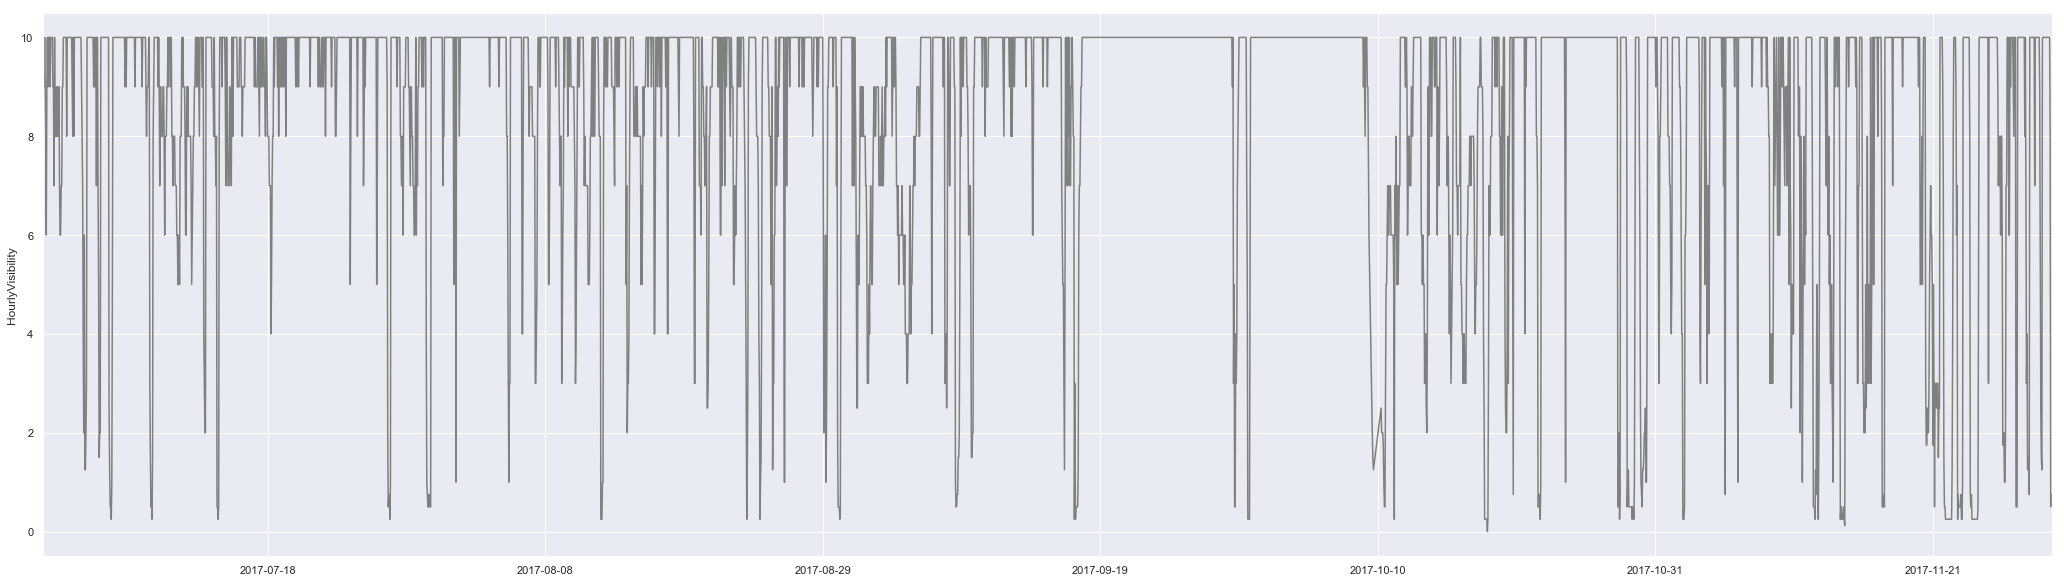

In [51]:
_ = plt.clf()
fig = plt.figure()
x = sr_We.index
y = 'HourlyVisibility'
_ = sns.lineplot(x, y, data=sr_We, color=VIS_COLOR)
_ = plt.xlim('2017-07-01', '2017-11-30')
#_ = plt.xlabel(x)
_ = plt.ylabel(y)
fig.set_size_inches(36, 10)
plt.show()

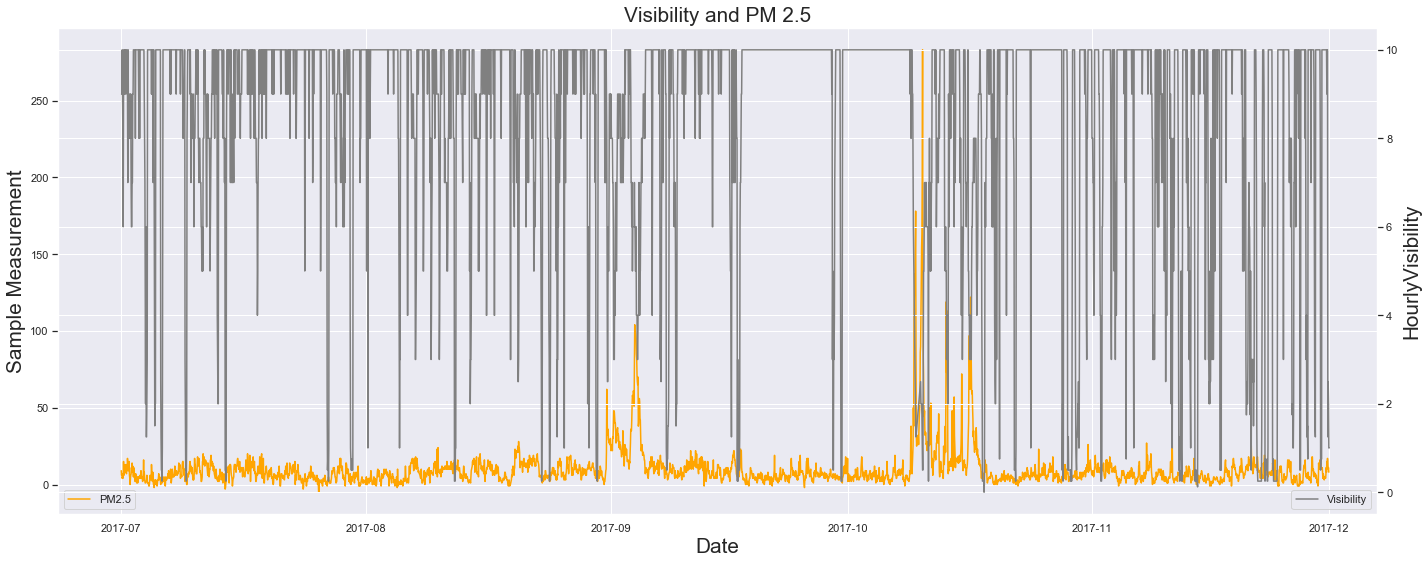

In [52]:
# plot full range of dates with visibility and PM2.5 
# converted to a function so that it can be called later to try different overlays

def plot_full_range():
    _ = plt.clf()
    fig, ax1 = plt.subplots()
    x1 = sr_25.index
    y1 = 'Sample Measurement'
    _ = sns.lineplot(x1, y1, data=sr_25, color=PM25_COLOR, label='PM2.5')
    _ = ax1.set_ylabel(y1, fontsize='xx-large')
    _ = ax1.set_xlabel('Date', fontsize='xx-large')
    _ = ax1.legend(loc='lower left')

    ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
    x2 = sr_We.index
    y2 = 'HourlyVisibility'
    _ = ax2.set_ylabel(y2, fontsize='xx-large')
    _ = sns.lineplot(x2, y2, data=sr_We, color=VIS_COLOR, label='Visibility')

    _ = plt.title('Visibility and PM 2.5', fontsize='xx-large')
    _ = plt.xlim('2017-06-23', '2017-12-07')
    _ = ax2.set_xlabel('Date', fontsize='xx-large')
    _ = ax2.legend(loc='lower right')
    fig.set_size_inches(20, 8)
    fig.tight_layout()
    return fig, ax1, ax2
    
plot_full_range()
plt.show()

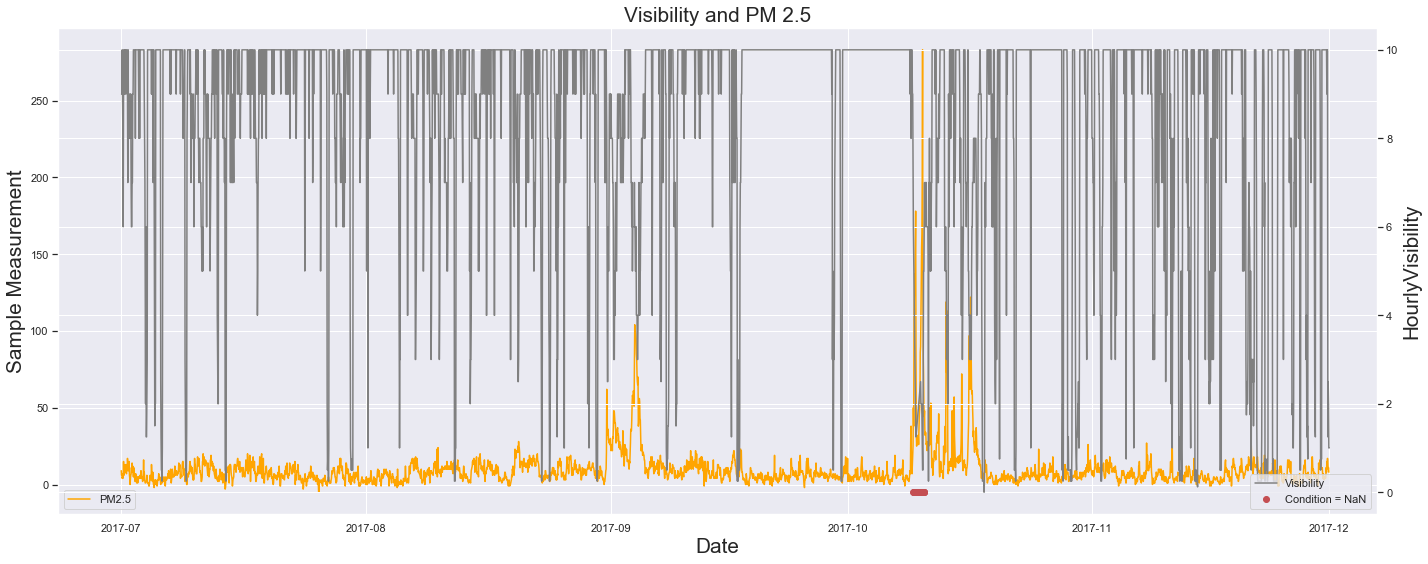

2017-10-09 07:00:00
2017-10-10 17:00:00


In [67]:
# plot a band across the top that shows when a given condition exists
#cond_str = 'VV:09 2'   # set this string to the substring you want to show against the data
cond_str = 'NaN'

# uncomment the next line and the cond_str line to show conditions
#cond_indices = sr_We[sr_We['HourlySkyConditions'].str.contains(cond_str, na=False)].index

#comment the next line if showing condition instead of NaN
cond_indices = sr_We[sr_We['HourlySkyConditions'].isna()].index

fig, ax1, ax2 = plot_full_range()
plt.plot(cond_indices, len(cond_indices) * [0], 'ro', label='Condition = ' + cond_str)
plt.legend(loc='lower right')
plt.show()

print(cond_indices[0])
print(cond_indices[-1])

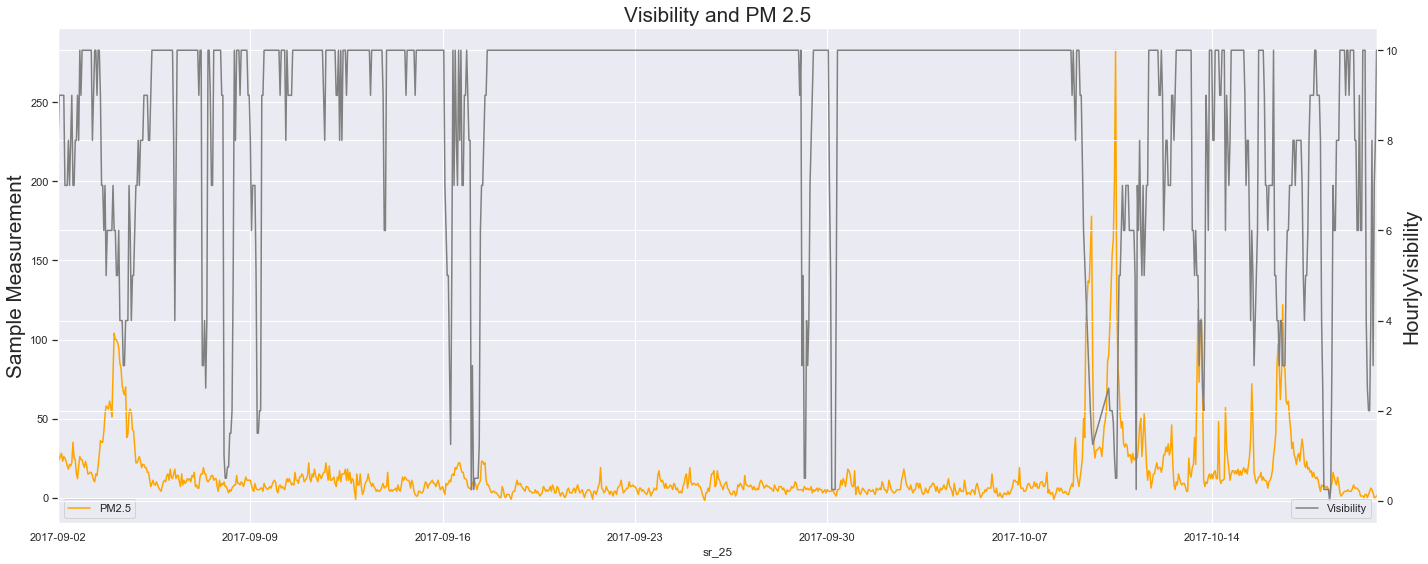

In [54]:
# plot narrower range of dates with Visibility and PM2.5; dates found just below['2017-09-02':'2017-10-20']

# create a date time slice to use in all references
st_date = '2017-09-02'
en_date = '2017-10-20'
dateslice = slice(st_date, en_date)

_ = plt.clf()
fig, ax1 = plt.subplots()
x1 = sr_25[dateslice].index
y1 = 'Sample Measurement'
_ = ax1.set_ylabel(y1, fontsize='xx-large')
_ = sns.lineplot(x1, y1, data=sr_25[dateslice], color=PM25_COLOR, label='PM2.5') #, hue='aqi_color')
_ = ax1.legend(loc='lower left')

ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
x2 = sr_We[dateslice].index
y2 = 'HourlyVisibility'
_ = ax2.set_ylabel(y2, fontsize='xx-large')
_ = sns.lineplot(x2, y2, data=sr_We[dateslice], color=VIS_COLOR, label='Visibility')

_ = plt.title('Visibility and PM 2.5', fontsize='xx-large')
_ = plt.xlim(st_date, en_date)
_ = ax2.set_xlabel('Date', fontsize='xx-large')
_ = ax2.legend(loc='lower right')
fig.set_size_inches(20, 8)
fig.tight_layout()
plt.show()

,Sample Measurement,HourlyVisibility
2017-07-01 01:00:00,6.0,9.0
2017-07-01 02:00:00,7.0,9.0
2017-07-01 03:00:00,4.0,10.0
2017-07-01 04:00:00,5.0,9.0
2017-07-01 05:00:00,4.0,8.0


Pearson r = [[ 1.         -0.23312236]
 [-0.23312236  1.        ]]


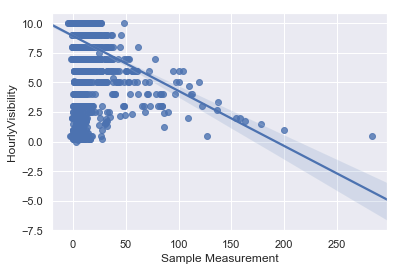

In [55]:
# plot regression of HourlyVisibility vs Sample Measurement

vis_25 = pd.concat([sr_25['Sample Measurement'], sr_We['HourlyVisibility']], axis='columns', join='inner')
display(vis_25.head())

x=vis_25['Sample Measurement']
y=vis_25['HourlyVisibility']
print ('Pearson r = {}'.format(np.corrcoef(x, y)))
_ = plt.clf()
ax = sns.regplot(x, y)
plt.show()

,Sample Measurement,HourlyVisibility
2017-08-31 12:00:00,62.0,8.0
2017-09-03 17:00:00,52.0,7.0
2017-09-03 18:00:00,58.0,5.0
2017-09-03 19:00:00,57.0,6.0
2017-09-03 20:00:00,56.0,6.0


Pearson r = [[ 1.         -0.64465584]
 [-0.64465584  1.        ]]


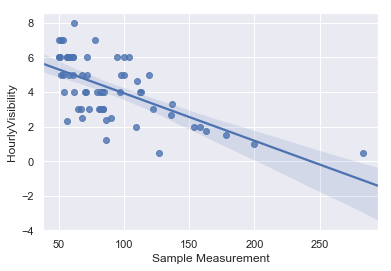

In [56]:
# plot regression of HourlyVisibility vs Sample Measurement on bad air days

bad_25 = vis_25[vis_25['Sample Measurement'] >= 50]
display(bad_25.head())

x=bad_25['Sample Measurement']
y=bad_25['HourlyVisibility']
print ('Pearson r = {}'.format(np.corrcoef(x, y)))
_ = plt.clf()
ax = sns.regplot(x, y)
plt.show()

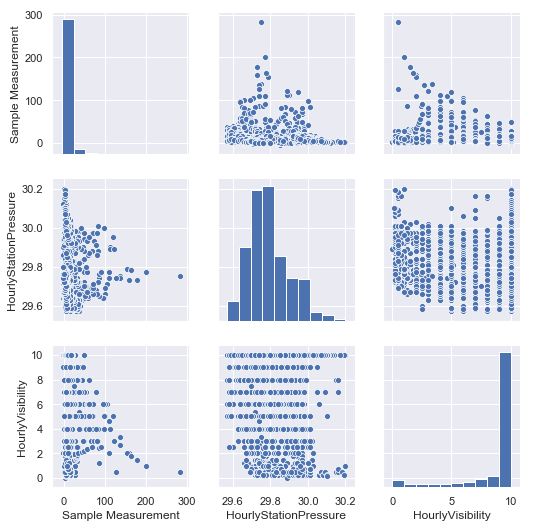

In [57]:
with_25 = pd.concat([sr_25['Sample Measurement'], sr_We], axis='columns', join='inner')
#print(with_25.info())

# getting error trying to plot with nulls....need to figure out how to deal with nulls in null_cols
#null_colls = ['HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure',  'HourlyWetBulbTermperature', 'HourlyWindGustSpeed','HourlyWindSpeed']
cols_to_plot = ['Sample Measurement', 'HourlyStationPressure', 'HourlyVisibility']

_ = plt.clf()
ax = sns.pairplot(data=with_25, vars=cols_to_plot)
plt.show()

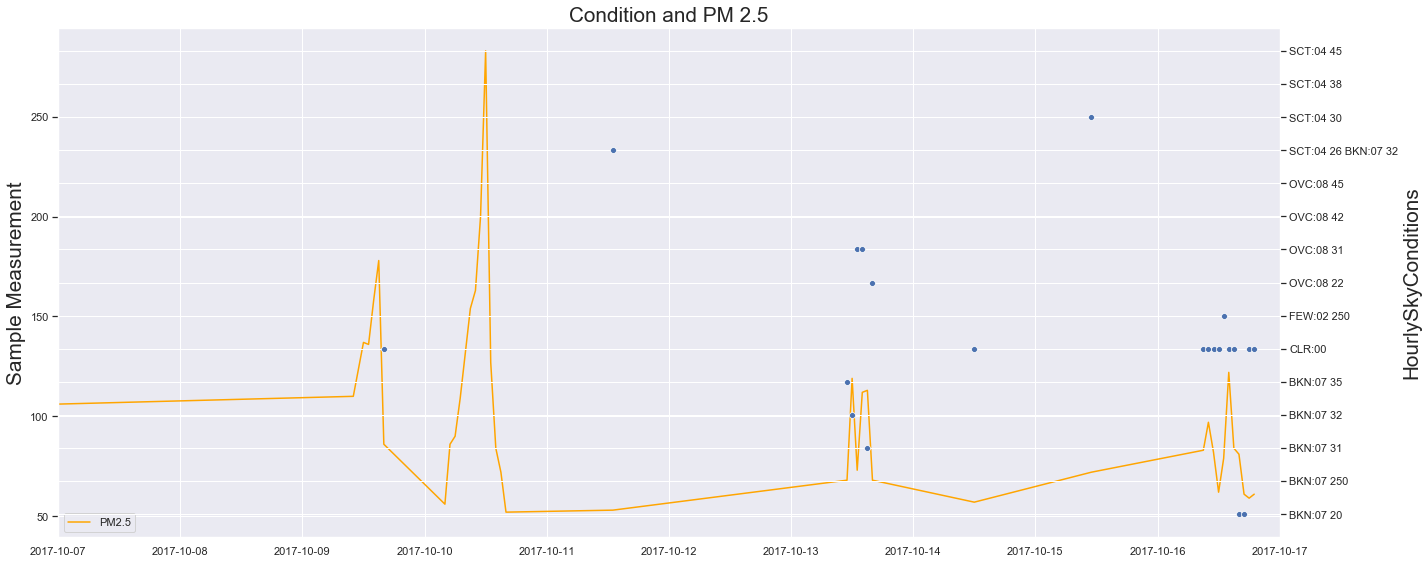

In [58]:
# show the value_counts for the SkyConditions when Sample Measurement is above 50

cond_over_50 = with_25[with_25['Sample Measurement'] > 50][['Sample Measurement','HourlySkyConditions']]
cond_over_50.head()
cond_over_50['HourlySkyConditions'] = cond_over_50['HourlySkyConditions'].astype('category')
_ = plt.clf()

fig, ax1 = plt.subplots()
x1 = cond_over_50.index
y1 = 'Sample Measurement'
_ = ax1.set_ylabel(y1, fontsize='xx-large')
_ = sns.lineplot(x1, y1, data=cond_over_50, color=PM25_COLOR, label='PM2.5') #, hue='aqi_color')
_ = ax1.legend(loc='lower left')

ax2 = ax1.twinx()  # instantiate a second axis that shares the same x-axis
x2 = cond_over_50.index
y2 = 'HourlyVisibility'
_ = ax2.set_ylabel(y2, fontsize='xx-large')
_ = sns.scatterplot(cond_over_50.index, cond_over_50['HourlySkyConditions'])
#_ = sns.lineplot(x2, y2, data=cond_over_50, color=VIS_COLOR, label='Visibility')

_ = plt.title('Condition and PM 2.5', fontsize='xx-large')
_ = plt.xlim('2017-10-07', '2017-10-17')
_ = ax2.set_xlabel('Date', fontsize='xx-large')
_ = ax2.legend(loc='lower right')
fig.set_size_inches(20, 8)
fig.tight_layout()

#plt.title('PM2.5 for Summer 2017', fontsize='xx-large')
#plt.xlabel('Date', fontsize='xx-large')
#plt.ylabel('Partical 2.5 Measurement', fontsize='xx-large')
#plt.legend(fontsize='xx-large')

plt.show()

In [59]:
print(cond_over_50.loc['2017-10-07':'2017-10-17','HourlySkyConditions'].value_counts(dropna=False))
cond_over_50['HourlySkyConditions'].value_counts(dropna=False)

NaN                    17
CLR:00                 10
OVC:08 31               2
BKN:07 20               2
SCT:04 30               1
SCT:04 26 BKN:07 32     1
OVC:08 22               1
FEW:02 250              1
BKN:07 35               1
BKN:07 32               1
BKN:07 31               1
SCT:04 45               0
SCT:04 38               0
OVC:08 45               0
OVC:08 42               0
BKN:07 250              0
Name: HourlySkyConditions, dtype: int64


CLR:00                 25
NaN                    17
SCT:04 45               2
OVC:08 42               2
OVC:08 31               2
BKN:07 250              2
BKN:07 20               2
SCT:04 38               1
SCT:04 30               1
SCT:04 26 BKN:07 32     1
OVC:08 45               1
OVC:08 22               1
FEW:02 250              1
BKN:07 35               1
BKN:07 32               1
BKN:07 31               1
Name: HourlySkyConditions, dtype: int64